In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [2]:
r = readers.CollectionReader('../src/beta_kl/agents')

100%|██████████| 400/400 [00:28<00:00, 13.95it/s]


In [3]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
#nadv = r.df('normalized_advantage')
#nadv['opt_step'] = (nadv.index % 50) * 10
#constraints = r.df('paper_constraints_train')
#constraints_heldout = r.df('paper_constraints_heldout')

In [4]:
games =  ["MountainCarContinuous-v0", "Pendulum-v0", "InvertedPendulum-v2",
          "Humanoid-v2", "InvertedDoublePendulum-v2"]
code_level_opts = {
      "kl_penalty_coeff": [0.1, 1, 3, 10],
      "kl_penalty_direction": ["new_to_old", "old_to_new"],
      #'clip_advantages': [1e8],
      #'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [5]:
#metadata['kl_penalty'] = (metadata['kl_penalty_coeff'] > 0)
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
#constraints = constraints.merge(key_metadata, on='exp_id')
#constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
#nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

# Plot mean rewards

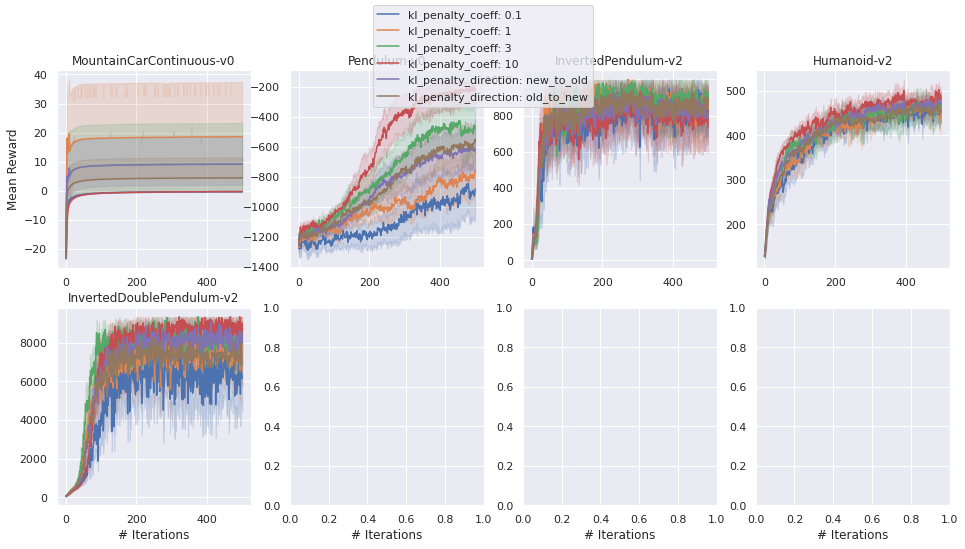

In [6]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    for i, cl_opt in enumerate(code_level_opts):
        for b in code_level_opts[cl_opt]:
            filt = opt[(opt[cl_opt] == b) & (opt.game == g)]
            sns.lineplot(filt.opt_step, filt.mean_reward,
                         ax=ax.flatten()[j], label=f"{cl_opt}: {b}", legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Reward')
ax[1][0].set_xlabel('Mean Reward')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

plt.show()

# Plot cumulative distribution of max rewards

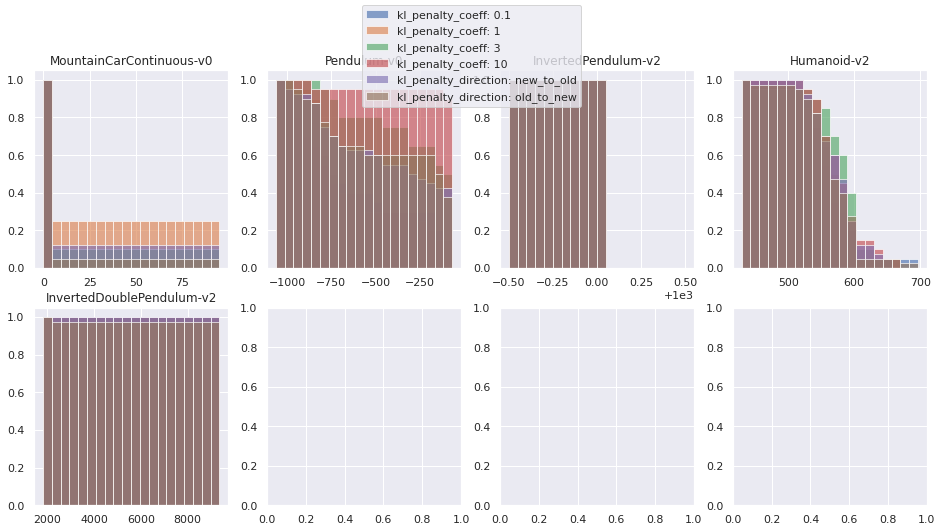

In [7]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            ax.flatten()[j].bar(bin_locs, hist, label=f"{cl_opt}: {b}",
                                **kwargs)
        ax.flatten()[j].set_title(g)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Plot distribution of max rewards

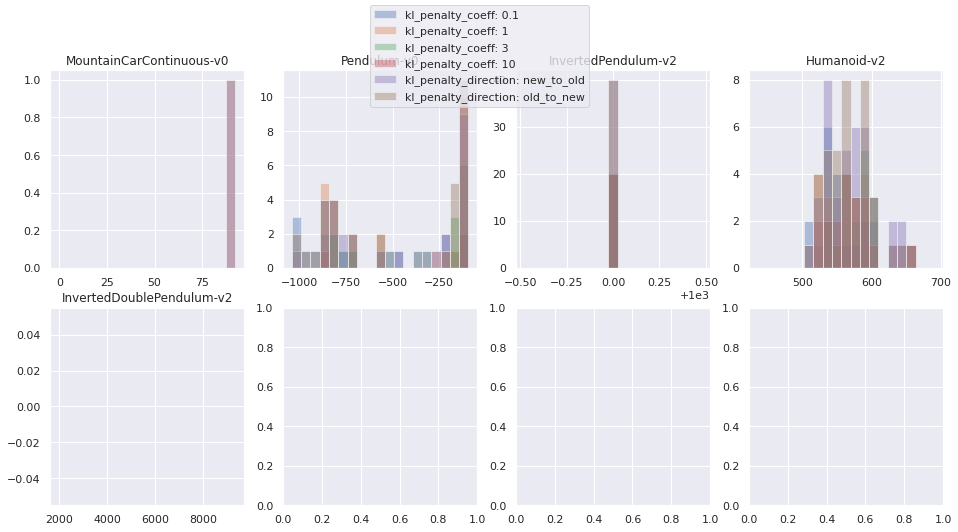

In [8]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            #hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            #hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            sns.distplot(filt['mean_reward'].tolist(),
                         bins=bin_locs, label=f"{cl_opt}: {b}", ax=ax.flatten()[j], kde=False)
        ax.flatten()[j].set_title(g)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Aggregate performance in normalized scores

In [9]:
max_and_min = max_rewards[['game', 'mean_reward']].groupby('game').max().rename(
    columns={'mean_reward': 'max_max_reward'})
max_and_min['min_max_reward'] = max_rewards[['game', 'mean_reward']].groupby('game').min()

In [10]:
ks = ['game'] + list(code_level_opts.keys())
grouped = max_rewards[ks + ['mean_reward']].groupby(ks).mean().reset_index().set_index(ks)
grouped = grouped.rename(columns={'mean_reward': 'mean_max_reward'})
grouped['stddev'] = max_rewards[ks + ['mean_reward']].groupby(ks).var().reset_index().set_index(ks).apply(np.sqrt)
grouped = grouped.reset_index()
grouped = grouped.reset_index().merge(max_and_min, on='game')
grouped = grouped.set_index(ks)
grouped['normalized_score'] = (grouped['mean_max_reward'] - grouped['min_max_reward']) / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped['normalized_stddev'] = grouped['stddev'] / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped = grouped.dropna()
grouped

index  \
game                      kl_penalty_coeff kl_penalty_direction          
Humanoid-v2               0.1              new_to_old                0   
                                           old_to_new                1   
                          1.0              new_to_old                2   
                                           old_to_new                3   
                          3.0              new_to_old                4   
                                           old_to_new                5   
                          10.0             new_to_old                6   
                                           old_to_new                7   
InvertedDoublePendulum-v2 0.1              new_to_old                8   
                                           old_to_new                9   
                          1.0              new_to_old               10   
                                           old_to_new               11   
                          3.0              new_to_old               12   
                                           old_to_new               13   
                          10.0             new_to_old               14   
                                           old_to_new               15   
MountainCarContinuous-v0  0.1              new_to_old               24   
                                           old_to_new               25   
                          1.0              new_to_old               26   
                                           old_to_new               27   
                          3.0              new_to_old               28   
                                           old_to_new               29   
                          10.0             new_to_old               30   
                                           old_to_new               31   
Pendulum-v0               0.1              new_to_old               32   
                                           old_to_new               33   
                          1.0              new_to_old               34   
                                           old_to_new               35   
                          3.0              new_to_old               36   
                                           old_to_new               37   
                          10.0             new_to_old               38   
                                           old_to_new               39   

                                                                 mean_max_reward  \
game                      kl_penalty_coeff kl_penalty_direction                    
Humanoid-v2               0.1              new_to_old                 555.916853   
                                           old_to_new                 563.985303   
                          1.0              new_to_old                 560.332589   
                                           old_to_new                 565.183724   
                          3.0              new_to_old                 590.658389   
                                           old_to_new                 559.664032   
                          10.0             new_to_old                 578.730674   
                                           old_to_new                 570.633380   
InvertedDoublePendulum-v2 0.1              new_to_old                9349.622669   
                                           old_to_new                9348.793570   
                          1.0              new_to_old                9347.483458   
                                           old_to_new                8593.183553   
                          3.0              new_to_old                9345.525920   
                                           old_to_new                9341.569711   
                          10.0             new_to_old                9339.927225   
                                           old_to_new                9337.157224   
MountainCarContinuous-v0  0.1       

In [11]:
ks = ['game'] + list(code_level_opts.keys())
tmp = max_rewards[ks + ['mean_reward']].merge(max_and_min, on='game')
tmp['normalized_score'] = (tmp['mean_reward'] - tmp['min_max_reward']) / (
    tmp['max_max_reward'] - tmp['min_max_reward'])
normalized_score = tmp[['game', 'kl_penalty_direction', 'normalized_score']]
normalized_score['game'] = normalized_score['game'].apply(lambda s: s.strip('-v2'))

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


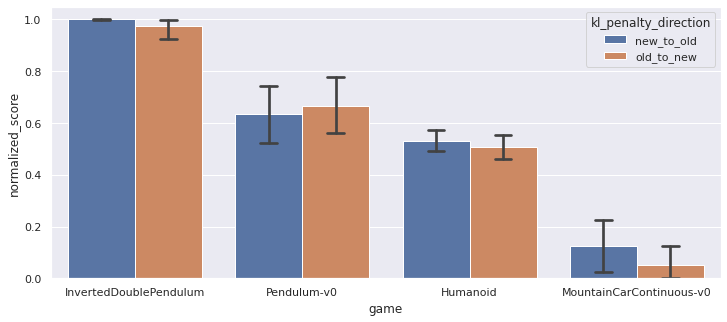

In [12]:
plt.figure(figsize=(12, 5))
sns.barplot(x="game", y="normalized_score", hue="kl_penalty_direction", data=normalized_score.dropna().reset_index(), capsize=.1)

In [13]:
normalized_score.groupby('kl_penalty_direction').describe()

normalized_score                                     \
                                count      mean       std  min       25%   
kl_penalty_direction                                                       
new_to_old                      160.0  0.572045  0.400926  0.0  0.203865   
old_to_new                      160.0  0.549484  0.410303  0.0  0.042219   

                                               
                           50%       75%  max  
kl_penalty_direction                           
new_to_old            0.585956  0.998245  1.0  
old_to_new            0.561058  0.996997  1.0